# Build a LSTM RNN Model to predict the trajectory of the Shuttlecock


### Step 1: Examine the Dataset
The dataset being used is called "cleaned_badminton_v2". It contains 13 columns and 168843 rows.
However, if we investigate the data, we can realise that a set of rows forms a trajectory of 1 shuttlecock. 
Hence, the column "OBSERVATION GROUP NUMBER" will represent the number of set and 
the column "OBSERVATION NUMBER" is a time series measured in 1/10 ms

In [1]:
# Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Multiply
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras_tuner.tuners import RandomSearch
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras_tuner.engine.hyperparameters import HyperParameters
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Activation
from keras import regularizers
from keras.optimizers import Adam
from keras import layers, regularizers
import plotly.offline as offline

In [2]:
# Load the csv file
data = pd.read_csv('cleaned_badminton_v2.csv')
data = data.drop(columns=['Unnamed: 0'])
data

HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
0                                      4                                 1   
1                                      4                                 1   
2                                      4                                 1   
3                                      4                                 1   
4                                      4                                 1   
...                                  ...                               ...   
168837                                 4                                 4   
168838                                 4                                 4   
168839                                 4                                 4   
168840                                 4                                 4   
168841                                 4                                 4   

        INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
0                                          10   
1                                          10   
2                                          10   
3                                          10   
4                                          10   
...                                       ...   
168837                                     70   
168838                                     70   
168839                                     70   
168840                                     70   
168841                                     70   

        INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  \
0                                              40   
1                                              40   
2                                              40   
3                                              40   
4                                              40   
...                                           ...   
168837                                         70   
168838                                         70   
168839                                         70   
168840                                         70   
168841                                         70   

        SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
168837                                           50   
168838                                           50   
168839                                           50   
168840                                           50   
168841                                           50   

        SHUTTLECOCK POSITIION IN AIR(X ) metres  \
0                                      4.075543   
1                                      4.152007   
2                                      4.228906   
3                                      4.302100   
4                                      4.376877   
...                                         ...   
168837                                 9.276323   
168838                                 9.326762   
168839                                 9.373273   
168840                                 9.414002   
168841                                 9.447133   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
0                                     1.000000   
1                                     1.000000   
2                                     1.000000   
3                                     1.000000   
4                                     1.000000   
...                                        ...   
168837                               10.288077   
168838                               10.348188   
168839                               10.403617   
168840                               10.452156   
168841               

In [3]:
# We need to preprocess the data before using it to train the model. 
# Firstly, change the values of Serving Shot because values of it are given such that 
# when 'serving shot' = 1, actual value = 1.6m
# when 'serving shot' = 0, actual value = 2.6m

# Iterate over each row in the dataset
for index, row in data.iterrows():
    # Check the value of column 11
    if row[10] == 1:
        # If the value is 1, change it to 1.6
        data.at[index, 'SERVING SHOT'] = 1.6
    elif row[10] == 0:
        # If the value is 0, change it to 2.6
        data.at[index, 'SERVING SHOT'] = 2.6

# Change the header of column 11
data.rename(columns={'SERVING SHOT': 'HEIGHT OF SHOT(m)'}, inplace=True)
data

HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
0                                      4                                 1   
1                                      4                                 1   
2                                      4                                 1   
3                                      4                                 1   
4                                      4                                 1   
...                                  ...                               ...   
168837                                 4                                 4   
168838                                 4                                 4   
168839                                 4                                 4   
168840                                 4                                 4   
168841                                 4                                 4   

        INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
0                                          10   
1                                          10   
2                                          10   
3                                          10   
4                                          10   
...                                       ...   
168837                                     70   
168838                                     70   
168839                                     70   
168840                                     70   
168841                                     70   

        INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  \
0                                              40   
1                                              40   
2                                              40   
3                                              40   
4                                              40   
...                                           ...   
168837                                         70   
168838                                         70   
168839                                         70   
168840                                         70   
168841                                         70   

        SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
168837                                           50   
168838                                           50   
168839                                           50   
168840                                           50   
168841                                           50   

        SHUTTLECOCK POSITIION IN AIR(X ) metres  \
0                                      4.075543   
1                                      4.152007   
2                                      4.228906   
3                                      4.302100   
4                                      4.376877   
...                                         ...   
168837                                 9.276323   
168838                                 9.326762   
168839                                 9.373273   
168840                                 9.414002   
168841                                 9.447133   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
0                                     1.000000   
1                                     1.000000   
2                                     1.000000   
3                                     1.000000   
4                                     1.000000   
...                                        ...   
168837                               10.288077   
168838                               10.348188   
168839                               10.403617   
168840                               10.452156   
168841               

In [4]:
# Secondly, we need to change the column "Observation Number" into time series. 
# In the project description, it is given that each records' interval = 10ms.
# Hence, it should be starting from 0, and increament += 0.1, for each set of "OBSERVATION GROUP" 
# Then change the Column Header to "TIME SERIES(s)"

In [5]:
# Find Unique values of "OBSERVATION NUMBER GROUP" in a list
unique_observation_group_ids = data['OBSERVATION GROUP NUMBER'].unique()

# Iterate over the unique group IDs
for group_id in unique_observation_group_ids:
    # Filter the DataFrame for the current group ID
    group_data = data[data['OBSERVATION GROUP NUMBER'] == group_id]
    
    # Get the number of rows in the current group
    num_rows = len(group_data)
    
    # Calculate the "OBSERVATION NUMBER" values for the current group
    observation_numbers = [0.1 * i for i in range(num_rows)]
    
    # Update the "OBSERVATION NUMBER" column values for the current group
    data.loc[group_data.index, "OBSERVATION NUMBER"] = observation_numbers
    
# # Reset the index of the DataFrame
# data.reset_index(drop=True, inplace=True)

data.rename(columns={'OBSERVATION NUMBER': 'TIME SERIES(s)'}, inplace=True)
data

HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
0                                      4                                 1   
1                                      4                                 1   
2                                      4                                 1   
3                                      4                                 1   
4                                      4                                 1   
...                                  ...                               ...   
168837                                 4                                 4   
168838                                 4                                 4   
168839                                 4                                 4   
168840                                 4                                 4   
168841                                 4                                 4   

        INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
0                                          10   
1                                          10   
2                                          10   
3                                          10   
4                                          10   
...                                       ...   
168837                                     70   
168838                                     70   
168839                                     70   
168840                                     70   
168841                                     70   

        INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  \
0                                              40   
1                                              40   
2                                              40   
3                                              40   
4                                              40   
...                                           ...   
168837                                         70   
168838                                         70   
168839                                         70   
168840                                         70   
168841                                         70   

        SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
168837                                           50   
168838                                           50   
168839                                           50   
168840                                           50   
168841                                           50   

        SHUTTLECOCK POSITIION IN AIR(X ) metres  \
0                                      4.075543   
1                                      4.152007   
2                                      4.228906   
3                                      4.302100   
4                                      4.376877   
...                                         ...   
168837                                 9.276323   
168838                                 9.326762   
168839                                 9.373273   
168840                                 9.414002   
168841                                 9.447133   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
0                                     1.000000   
1                                     1.000000   
2                                     1.000000   
3                                     1.000000   
4                                     1.000000   
...                                        ...   
168837                               10.288077   
168838                               10.348188   
168839                               10.403617   
168840                               10.452156   
168841               

In [6]:
# Now we have the actual data. 
# However, there is a need to convert the Angles in Radient Forms because when Degree form is used in Normalization,
# it may not produce meaningful result the values are cyclic (e.g. 360 degree = 0 degree)

In [7]:
# Convert degrees to radians for the specified columns
data['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'] = np.deg2rad(data['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'])
data['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = np.deg2rad(data['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'])

data

HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
0                                      4                                 1   
1                                      4                                 1   
2                                      4                                 1   
3                                      4                                 1   
4                                      4                                 1   
...                                  ...                               ...   
168837                                 4                                 4   
168838                                 4                                 4   
168839                                 4                                 4   
168840                                 4                                 4   
168841                                 4                                 4   

        INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
0                                          10   
1                                          10   
2                                          10   
3                                          10   
4                                          10   
...                                       ...   
168837                                     70   
168838                                     70   
168839                                     70   
168840                                     70   
168841                                     70   

        INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  \
0                                        0.698132   
1                                        0.698132   
2                                        0.698132   
3                                        0.698132   
4                                        0.698132   
...                                           ...   
168837                                   1.221730   
168838                                   1.221730   
168839                                   1.221730   
168840                                   1.221730   
168841                                   1.221730   

        SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  \
0                                          0.000000   
1                                          0.000000   
2                                          0.000000   
3                                          0.000000   
4                                          0.000000   
...                                             ...   
168837                                     0.872665   
168838                                     0.872665   
168839                                     0.872665   
168840                                     0.872665   
168841                                     0.872665   

        SHUTTLECOCK POSITIION IN AIR(X ) metres  \
0                                      4.075543   
1                                      4.152007   
2                                      4.228906   
3                                      4.302100   
4                                      4.376877   
...                                         ...   
168837                                 9.276323   
168838                                 9.326762   
168839                                 9.373273   
168840                                 9.414002   
168841                                 9.447133   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
0                                     1.000000   
1                                     1.000000   
2                                     1.000000   
3                                     1.000000   
4                                     1.000000   
...                                        ...   
168837                               10.288077   
168838                               10.348188   
168839                               10.403617   
168840                               10.452156   
168841               

In [8]:
# data.to_csv("new_data.csv")

In [9]:
# We have came to end of adjusting the values of data to be used.
# We will first split the data into testing and training set.
# However, we will not just randomly split by rows because it may result in a case where
# the first half rows of a set 2 is used for training phase
# but the last half rows of a set 2 is used during the testing phase

# Hence, we have split the data by number of sets, such that entire rows of the choosened sets would be used for training
# and rest are used for testing

In [10]:
# Get the unique subsets of shots in your dataset
unique_subsets = data['OBSERVATION GROUP NUMBER'].unique() # list of [1 to 1576]

# Shuffle the order of subsets randomly
random.shuffle(unique_subsets)

# Determine the number of subsets for training and testing
# num_train_subsets = int(0.8 * len(unique_subsets))  # 80% for training, adjust as needed
# print(num_train_subsets)


num_train_subsets = int(0.9 * len(unique_subsets))  # 90% for training, adjust as needed
print(num_train_subsets)


train_subsets = unique_subsets[:num_train_subsets]
test_subsets = unique_subsets[num_train_subsets:]
print("Length of train_subsets: ", len(train_subsets))
print("Length of test_subsets: ", len(test_subsets))

# Filter the dataset based on the assigned subsets
train_data = data[data['OBSERVATION GROUP NUMBER'].isin(train_subsets)]
test_data = data[data['OBSERVATION GROUP NUMBER'].isin(test_subsets)]

print("The shape of train_data: ",train_data.shape)
print("The Length of train_data: ",len(train_data))
print("The shape of test_data: ",test_data.shape)
print("The Length of test_data: ",len(test_data))


1418
Length of train_subsets:  1418
Length of test_subsets:  158
The shape of train_data:  (151734, 12)
The Length of train_data:  151734
The shape of test_data:  (17108, 12)
The Length of test_data:  17108


In [11]:
# After randomly separating the training dataset and testing dataset,
# there is a need to seprate each datasets into input feature X and ouput feature Y

# Split the X and Y features for training and testing
X_train = train_data[['HUMAN PLAYER POSITION (X) metres', 
                   'HUMAN PLAYER POSITION (Y) metres', 
                    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                    'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                    'TIME SERIES(s)',
                    'HEIGHT OF SHOT(m)']]

Y_train = train_data[['SHUTTLECOCK POSITIION IN AIR(X ) metres', 
                   'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                   'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

X_test = test_data[['HUMAN PLAYER POSITION (X) metres', 
                   'HUMAN PLAYER POSITION (Y) metres', 
                    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                    'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                    'TIME SERIES(s)',
                    'HEIGHT OF SHOT(m)']]

Y_test = test_data[['SHUTTLECOCK POSITIION IN AIR(X ) metres', 
                   'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                   'SHUTTLECOCK POSITIION IN AIR(Z) metres']]



In [12]:
print("The shape of X_train is: ", X_train.shape)
print("The shape of Y_train is: ", Y_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of Y_test is: ", Y_test.shape)

The shape of X_train is:  (151734, 7)
The shape of Y_train is:  (151734, 3)
The shape of X_test is:  (17108, 7)
The shape of Y_test is:  (17108, 3)


In [13]:
# X_features = data[['HUMAN PLAYER POSITION (X) metres', 
#                    'HUMAN PLAYER POSITION (Y) metres', 
#                     'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
#                     'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
#                     'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
#                     'TIME SERIES(s)',
#                     'HEIGHT OF SHOT(m)']]

# Y_features = data[['SHUTTLECOCK POSITIION IN AIR(X ) metres', 
#                    'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
#                    'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

# X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_features, test_size=0.2, random_state=42)

In [14]:
# Now, we need to scale the X features on a same scale because some features are in different units like (m, m/s, radiant, s)
# This is where normalization comes in to scale the feature between 0 and 1.

# Normalize the train, test X Y
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.fit_transform(X_test)
# # Y_train_normalized = scaler.fit_transform(Y_train)
# # Y_test_normalized = scaler.fit_transform(Y_test)
# print("Shape of X_train_normalized: ", X_train_normalized.shape)
# print("Shape of X_test_normalized: ", X_test_normalized.shape)


# without normalization
X_train_array = X_train.values
X_test_array = X_test.values


print("Shape of X_train_array: ", X_train_array.shape)
print("Shape of X_test_array: ", X_test_array.shape)

# Convert X_features and Y_features to NumPy arrays
# Y_train_array = Y_train_normalized
# Y_test_array = Y_test_normalized
Y_train_array = Y_train.values
Y_test_array = Y_test.values

Shape of X_train_array:  (151734, 7)
Shape of X_test_array:  (17108, 7)


In [15]:
# Use the RandomForestRegressor to find the importance of each features

# Create a Random Forest regressor
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train_array, Y_train_array)

# Get the feature importances
importances = rf_model.feature_importances_

# Print the feature importances
for feature, importance in zip(X_train.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature: HUMAN PLAYER POSITION (X) metres, Importance: 0.0
Feature: HUMAN PLAYER POSITION (Y) metres, Importance: 0.11318744883098841
Feature: INITITAL VELOCITY OF SHUTTELCOCK(m/s), Importance: 0.026637152258361205
Feature: INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE), Importance: 0.10712922672127355
Feature: SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE), Importance: 0.33161239555591854
Feature: TIME SERIES(s), Importance: 0.40813655136128774
Feature: HEIGHT OF SHOT(m), Importance: 0.013297225272170613


In [16]:
# # Function to build the LSTM model
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
#                    input_shape=(num_timesteps, num_features)))
#     model.add(Dense(units=3))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# # Reshape the input data to match the LSTM model input shape
# num_samples, num_features = X_train_normalized.shape
# num_timesteps = 1

# X_train_reshaped = X_train_normalized.reshape(num_samples, num_timesteps, num_features)

# # Add padding to the X_train_sets to ensure consistenet length
# # Set the maximum length for padding
# max_length = 153

# # Apply padding to each set
# X_train_padded = []
# for set_data in X_train_reshaped:
#     padded_set = pad_sequences(set_data, maxlen=max_length, padding='post', truncating='post')
#     X_train_padded.append(padded_set)

# # Convert the list back to a NumPy array
# X_train_padded = np.array(X_train_padded)
# print("The shape of X_train_padded: ", X_train_padded.shape)

# # Define the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=5,
#     directory='tuner_dir',
#     project_name='lstm_hyperparameter_tuning'
# )

# # Perform hyperparameter tuning
# tuner.search(X_train_reshaped, Y_train_array, epochs=10, validation_split=0.2)

# # Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Predict the shuttlecock trajectory
# num_samples, num_features = X_test_normalized.shape
# X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], num_timesteps, num_features)

# y_pred = best_model.predict(X_test_reshaped)

# scaler = MinMaxScaler()
# y_pred = scaler.fit_transform(y_pred)
# print(y_pred)
# print(Y_test_array)


# accuracy = mean_absolute_error(Y_test_array, y_pred)
# mse = mean_squared_error(Y_test_array, y_pred)
# rmse = np.sqrt(mse)

# print(accuracy)
# print(mse)
# print(rmse)

In [17]:


# # Function to build the LSTM model
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
#                    input_shape=(None, num_features)))  # Use None instead of max_length
#     model.add(Dense(units=3))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model


# # Reshape the input data to match the LSTM model input shape
# num_samples, num_features = X_train_array.shape

# # Reshape the training data
# X_train_reshaped = X_train_array.reshape(num_samples, -1, num_features)

# # Define the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=3,
#     directory='tuner_dir',
#     project_name='lstm_hyperparameter_tuning'
# )

# # Perform hyperparameter tuning
# tuner.search(X_train_reshaped, Y_train_array, epochs=10, validation_split=0.2)

# # Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Reshape the test data
# num_samples_test, _ = X_test_array.shape
# X_test_reshaped = X_test_array.reshape(num_samples_test, -1, num_features)
# print("The shape of X_test_reshaped: ", X_test_reshaped.shape)

# # Predict the shuttlecock trajectory
# y_pred = best_model.predict(X_test_reshaped)

# # scaler = MinMaxScaler()
# # y_pred = scaler.fit_transform(y_pred)
# print(y_pred)
# print(Y_test_array)

# mae = mean_absolute_error(Y_test_array, y_pred)
# mse = mean_squared_error(Y_test_array, y_pred)
# rmse = np.sqrt(mse)

# print("The mean_absolute_error: ", mae)
# print("The mean_squared_error: ", mse)
# print("The root_mean_squred_error: ", rmse)

In [18]:
#Function to build the LSTM model (Working Model: 0.11-0.14)
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
# #                    return_sequences=True,  # Add this line to return sequences from the first LSTM layer
#                    input_shape=(None, num_features)))  
# #     model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32)))
#     model.add(Dense(units=3))
#     model.add(Activation('linear'))  # Set the activation function to ReLU
#     model.compile(loss='mean_squared_error', optimizer='adam')
# #     model.compile(loss='mean_absolute_error', optimizer='adam')
#     return model

# Function to build the LSTM model (With EarlyStop: Most recent)
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=16, max_value=256, step=32), 
#                    input_shape=(None, num_features)))  
#     model.add(Dense(units=3))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

################################ So far most accurate 
def build_model(hp):
    model = Sequential()
    
    #Input Layer with  minimum 16 - 256 units that can take in input X shape of (flexible sample, 7)
    # By default activation functin = tanh
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=256, step=32), 
                   input_shape=(None, num_features),
                   return_sequences=True))  # Add return_sequences=True to retain the sequence output
    
    # By default activation functin = tanh (capture non-linear pattern)
    model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=256, step=32)))  # Add an additional LSTM layer
    
    # Output layer which captures linear pattern and outputs a array of 3 features
    model.add(Dense(units=3))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=16, max_value=256, step=32), 
#                    input_shape=(None, num_features)))
#     model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=256, step=32)))
#     model.add(Activation('relu'))
#     model.add(Dense(units=3))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model



# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
#                    input_shape=(None, num_features),
#                    kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#     model.add(Dense(units=3))
#     model.add(BatchNormalization())
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
#     # Add early stopping callback
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
#     return model

# def build_model(hp): (Working with rsme: 0.15)
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
#                    input_shape=(None, num_features)))
#     model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
#                     activation='relu',
#                     kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(BatchNormalization())
#     model.add(Dense(units=3))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
#                    return_sequences=True, 
#                    input_shape=(None, num_features),
#                    kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1])))) 
    
#     model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
#                    kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1]))))
    
#     model.add(Dense(units=3))
#     model.add(layers.Activation('linear'))

#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(loss='mean_squared_error', optimizer=optimizer)

#     return model



# Reshape the input data to match the LSTM model input shape
num_samples, num_features = X_train_array.shape
X_train_weighted = X_train_array * importances
X_train_weighted_reshaped = X_train_weighted.reshape(num_samples, -1, num_features)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='tuner_dir',
    project_name='lstm_hyperparameter_tuning'
)

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter tuning with early stopping
tuner.search(X_train_weighted_reshaped, Y_train_array, epochs=15, validation_split=0.1, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Multiply the feature importance weights with the test data
X_test_weighted = X_test_array * importances

# Reshape the weighted test data
num_samples_test, _ = X_test_weighted.shape
X_test_weighted_reshaped = X_test_weighted.reshape(num_samples_test, -1, num_features)

# Predict the shuttlecock trajectory
y_pred = best_model.predict(X_test_weighted_reshaped)

# Calculate the evaluation metrics
mae = mean_absolute_error(Y_test_array, y_pred)
mse = mean_squared_error(Y_test_array, y_pred)
rmse = np.sqrt(mse)

print("The mean_absolute_error: ", mae)
print("The mean_squared_error: ", mse)
print("The root_mean_squared_error: ", rmse)

print("The Summary of the best model: ",best_model.summary())

INFO:tensorflow:Reloading Tuner from tuner_dir\lstm_hyperparameter_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit
535/535 [==============================] - 1s 1ms/step
The mean_absolute_error:  0.10035758327310225
The mean_squared_error:  0.020474315160372694
The root_mean_squared_error:  0.14308848716920833
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 48)          10752     
                                                                 
 lstm_1 (LSTM)               (None, 48)                18624     
                                                                 
 dense (Dense)               (None, 3)                 147       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 

In [19]:
print(y_pred.shape)
print(num_features)
print(X_train_weighted_reshaped.shape)
print(X_train_array.shape)
print(X_train_weighted.shape)

(17108, 3)
7
(151734, 1, 7)
(151734, 7)
(151734, 7)


In [20]:
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import Sequential, layers
# from kerastuner.tuners import RandomSearch

# # Function to build the LSTM model with regularization and batch normalization
# def build_model(hp):
#     model = Sequential()
#     model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
#                           return_sequences=True,
#                           input_shape=(None, num_features),
#                           kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1]))))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
#                           kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1]))))
#     model.add(layers.Dense(units=3))
#     model.add(layers.Activation('linear'))

#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(loss='mean_squared_error', optimizer=optimizer)

#     return model

# # Reshape the input data to match the LSTM model input shape
# num_samples, num_features = X_train_array.shape
# # Multiply the feature importance weights with the input data
# X_train_weighted = X_train_array * importances

# # Reshape the weighted input data to match the LSTM model input shape
# X_train_weighted_reshaped = X_train_weighted.reshape(num_samples, -1, num_features)

# # Define the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=3,
#     directory='tuner_dir',
#     project_name='lstm_hyperparameter_tuning'
# )

# # Perform hyperparameter tuning with early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# tuner.search(X_train_weighted_reshaped, Y_train_array, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# # Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Multiply the feature importance weights with the test data
# X_test_weighted = X_test_array * importances

# # Reshape the weighted test data
# num_samples_test, _ = X_test_weighted.shape
# X_test_weighted_reshaped = X_test_weighted.reshape(num_samples_test, -1, num_features)

# # Predict the shuttlecock trajectory
# y_pred = best_model.predict(X_test_weighted_reshaped)

# # Calculate the evaluation metrics
# mae = mean_absolute_error(Y_test_array, y_pred)
# mse = mean_squared_error(Y_test_array, y_pred)
# rmse = np.sqrt(mse)

# print("The mean_absolute_error: ", mae)
# print("The mean_squared_error: ", mse)
# print("The root_mean_squared_error: ", rmse)


In [21]:
import plotly.graph_objects as go

# Create the 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=Y_test_array[:, 0],  # X-coordinate of the true values
        y=Y_test_array[:, 1],  # Y-coordinate of the true values
        z=Y_test_array[:, 2],  # Z-coordinate of the true values
        mode='markers',
        name='True Values',
        marker=dict(color='blue', size=2),
        opacity=0.7
    ),
    go.Scatter3d(
        x=y_pred[:, 0],  # X-coordinate of the predicted values
        y=y_pred[:, 1],  # Y-coordinate of the predicted values
        z=y_pred[:, 2],  # Z-coordinate of the predicted values
        mode='markers',
        name='Predicted Values',
        marker=dict(color='red', size=2),
        opacity=0.7
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='True Values vs Predicted Values',
    scene=dict(
        xaxis_title='X-coordinate',
        yaxis_title='Y-coordinate',
        zaxis_title='Z-coordinate'
    )
)

# Show the 3D plot
fig.show()


Epoch 1/15
3794/3794 [==============================] - 12s 2ms/step - loss: 8.1125e-04 - val_loss: 0.0256
Epoch 2/15
3794/3794 [==============================] - 8s 2ms/step - loss: 6.2785e-04 - val_loss: 0.0318
Epoch 3/15
3794/3794 [==============================] - 8s 2ms/step - loss: 5.4051e-04 - val_loss: 0.0333
Epoch 4/15
3794/3794 [==============================] - 9s 2ms/step - loss: 5.3349e-04 - val_loss: 0.0350
Epoch 5/15
3794/3794 [==============================] - 8s 2ms/step - loss: 4.5513e-04 - val_loss: 0.0331
Epoch 6/15
3794/3794 [==============================] - 9s 2ms/step - loss: 4.2750e-04 - val_loss: 0.0327
Epoch 7/15
3794/3794 [==============================] - 9s 2ms/step - loss: 3.8645e-04 - val_loss: 0.0328
Epoch 8/15
3794/3794 [==============================] - 9s 2ms/step - loss: 3.8318e-04 - val_loss: 0.0353
Epoch 9/15
3794/3794 [==============================] - 9s 2ms/step - loss: 4.2598e-04 - val_loss: 0.0388
Epoch 10/15
3794/3794 [======================

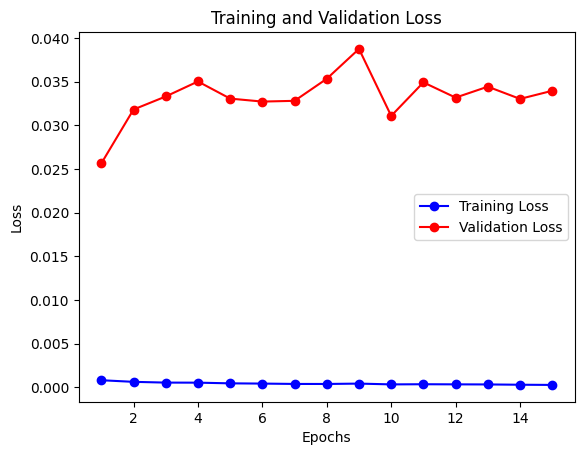

In [22]:
import matplotlib.pyplot as plt

# Train the model and collect training history
history = best_model.fit(X_train_weighted_reshaped, Y_train_array, validation_split=0.2, epochs=15)

# Plot training loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# Prof gives list of X [[x,y,z], [x,y,z], [x,y,z]...] = 1 trajectory

# first row of this X [x,y,z]
# (x = human x)
# (y = human y)
# (z = service height)
# (time series = number of rows in list) => start in 0, need to increase 0.1
# input.shape = (...., 7)

# input test =  [[x, y, 0,0,0,time_series,z], ... ]
# reshape () 

# go into the mode using predict:
#     sreis of x,y,z of the shuttlecock


# X_test = test_data[['HUMAN PLAYER POSITION (X) metres', 
#                    'HUMAN PLAYER POSITION (Y) metres', 
#                     'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
#                     'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
#                     'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
#                     'TIME SERIES(s)',
#                     'HEIGHT OF SHOT(m)']]



# # Robot part
# # 1. determine in or out (decision has to be made before highest point of the trajectory)
# # 2. Robot will not move if it is expected to be out
# #     3. So with 10 rows of predicted line, it need to decide whether to move
# #     4. Overall h of robot  +  racket = 120cm
# #     5. the badminton racket mounted on the robot is of length 68cm with overall width being 23cm
# #     6. Assume 30% of 68cm length of head and width of 23cm
# #     7. Assume 



In [24]:
# import pandas as pd
# import math

# # Read input data from CSV file
# df = test_data
# df

# # Round the X and Y columns
# first_human_player_position_x = df.loc[
#     0, "SHUTTLECOCK POSITIION IN AIR(X) metres"
# ].round()

# first_human_player_position_y = df.loc[
#     0, "SHUTTLECOCK POSITIION IN AIR(Y) metres"
# ].round()

# df["Human Player Position (X) metres"] = first_human_player_position_x
# df["Human Player Position (Y) metres"] = first_human_player_position_y

# # Calculate the HEIGHT OF SHOT in the first row
# first_row_height = (
#     math.floor(df.loc[0, "SHUTTLECOCK POSITIION IN AIR(Z) metres"] * 10) / 10
# )
# df["HEIGHT OF SHOT(m)"] = first_row_height

# # Set other columns to zero
# df["INITITAL VELOCITY OF SHUTTELCOCK(m/s)"] = 0
# df["INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)"] = 0
# df["SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)"] = 0
# df["OUT OF BOUNDS"] = 0

# # Generate the TIME SERIES column
# df["TIME SERIES(s)"] = df.index * 0.1

# # Set OBSERVATION GROUP NUMBER to 1
# df["OBSERVATION GROUP NUMBER"] = 1

# # Reorder the columns
# columns_order = [
#     "Human Player Position (X) metres",
#     "Human Player Position (Y) metres",
#     "INITITAL VELOCITY OF SHUTTELCOCK(m/s)",
#     "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
#     "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)",
#     "SHUTTLECOCK POSITIION IN AIR(X) metres",
#     "SHUTTLECOCK POSITIION IN AIR(Y) metres",
#     "SHUTTLECOCK POSITIION IN AIR(Z) metres",
#     "TIME SERIES(s)",
#     "OBSERVATION GROUP NUMBER",
#     "HEIGHT OF SHOT(m)",
#     "OUT OF BOUNDS",
# ]
# df = df[columns_order]

# # Print the resulting DataFrame
# print(df)
# # df.to_csv("test_data_processed.csv", index=False)


### ROBOT - Shuttlecock Trajectory Estimation

In [1]:
# import plotly.graph_objects as go

# DEF
test_size = 1

# Define court dimensions
court_length_x = 13.4
court_length_y = 5.18
court_height_skybox = 10
court_height_net = 1.55
court_length_centerline = 4.68

def is_point_within_court(x, y, z, court_length_x, court_length_y, court_height_skybox):
    """
    Check if a point is within the court boundaries.
    
    Args:
        x (float): X-coordinate of the point
        y (float): Y-coordinate of the point
        z (float): Z-coordinate of the point
        court_length_x (float): Length of the court along the X-axis
        court_length_y (float): Length of the court along the Y-axis
        court_height_skybox (float): Height of the court's skybox
    
    Returns:
        bool: True if the point is within the court boundaries, False otherwise
    """
    return 0 <= x <= court_length_x and 0 <= y <= court_length_y and 0 <= z <= court_height_skybox

# Generate 1 random subsets from the test subsets
random_subsets = np.random.choice(test_subsets, size=test_size, replace=False)

# Filter the test data based on the random subsets
random_test_data = test_data[test_data['OBSERVATION GROUP NUMBER'].isin(random_subsets)]

# Extract the features (X) from the random test data
X_random = random_test_data[['HUMAN PLAYER POSITION (X) metres',
                             'HUMAN PLAYER POSITION (Y) metres',
                             'INITITAL VELOCITY OF SHUTTELCOCK(m/s)',
                             'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)',
                             'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                             'TIME SERIES(s)',
                             'HEIGHT OF SHOT(m)']].values


# Multiply the feature importance weights with the random data
X_random_weighted = X_random * importances

# Reshape the weighted random data
num_samples_random, _ = X_random_weighted.shape
X_random_weighted_reshaped = X_random_weighted.reshape(num_samples_random, -1, num_features)

# Predict the shuttlecock trajectory using the best model
Y_random_pred = best_model.predict(X_random_weighted_reshaped)

# Extract the true values (Y) from the random test data
Y_random_true = random_test_data[['SHUTTLECOCK POSITIION IN AIR(X ) metres',
                                  'SHUTTLECOCK POSITIION IN AIR(Y) metres',
                                  'SHUTTLECOCK POSITIION IN AIR(Z) metres']].values


# Create the 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=Y_random_true[:, 0],  # X-coordinate of the true values
        y=Y_random_true[:, 1],  # Y-coordinate of the true values
        z=Y_random_true[:, 2],  # Z-coordinate of the true values
        mode='markers',
        name='True Values',
        marker=dict(color='blue', size=2),
        opacity=0.7
    ),
    go.Scatter3d(
        x=Y_random_pred[:, 0],  # X-coordinate of the predicted values
        y=Y_random_pred[:, 1],  # Y-coordinate of the predicted values
        z=Y_random_pred[:, 2],  # Z-coordinate of the predicted values
        mode='markers',
        name='Predicted Values (LSTM)',
        marker=dict(color='red', size=2),
        opacity=0.7
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Shuttlecock Trajectory Estimation',
    scene=dict(
        xaxis_title='X-coordinate',
        yaxis_title='Y-coordinate',
        zaxis_title='Z-coordinate',
        xaxis=dict(range=[-4, 18]),  # Set the range for X-axis
        yaxis=dict(range=[-2, 7]),   # Set the range for Y-axis
        zaxis=dict(range=[0, 12]),  # Set the range for Z-axis
        aspectmode='manual',         # Set the aspect mode to manual for custom scaling
        aspectratio=dict(x=1, y=1, z=1)  # Set the aspect ratio for equal scaling of axes
    )
)

# Add court lines to the plot
fig.add_trace(go.Scatter3d(
    x=[0, court_length_x, court_length_x, 0, 0],
    y=[0, 0, court_length_y, court_length_y, 0],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Court Boundaries',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[0, court_length_centerline, court_length_centerline, 0, 0],
    y=[court_length_y / 2, court_length_y / 2, court_length_y / 2, court_length_y / 2, court_length_y / 2],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Center Line',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x - court_length_centerline, court_length_x],
    y=[court_length_y / 2, court_length_y / 2],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Center Line',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_centerline + 0.04, court_length_centerline + 0.04],
    y=[0, court_length_y],
    z=[0, 0],
    mode='lines',
    name='Short Service Lines',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x - court_length_centerline - 0.04, court_length_x - court_length_centerline - 0.04],
    y=[0, court_length_y],
    z=[0, 0],
    mode='lines',
    name='Short Service Lines',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x / 2, court_length_x / 2],
    y=[0, court_length_y],
    z=[court_height_net, court_height_net],
    mode='lines',
    name='Net',
    line=dict(color='red', width=1)
))

# Initialize the count
all_within_court = True
highest_xyz_points = []
highest_z_index = np.argmax(Y_random_pred[:, 2])

# Check if all predicted values are within the court
for point in Y_random_pred:
    x, y, z = point
    if not is_point_within_court(x, y, z, court_length_x, court_length_y, court_height_skybox):
        all_within_court = False
        break
        
# Retrieve final XYZ if all predictions are within the court
# if all_within_court:
#     highest_xyz_points = Y_random_pred[-1]
#     highest_xyz_point = Y_random_pred[highest_z_index]
# else:
#     print("Predicted shuttlecock is out of court!")

color = "red"
predict = True
placeholder="Initial Starting Point (Miss)"
            
if not all_within_court:
    color = "black"
    predict = False
    placeholder="Initial Starting Point (OUT)"

highest_xyz_points = Y_random_pred[-1]
highest_xyz_point = Y_random_pred[highest_z_index]

# Print the count
print("Is predicted LSTM within court: ", all_within_court)
# Print the predicted XYZ values
print("XYZ of Estimated Shuttlecock Position:", highest_xyz_points)

# Add the predicted X, Y, and Z points to the graph
fig.add_trace(go.Scatter3d(
    x=[highest_xyz_points[0]],
    y=[highest_xyz_points[1]],
    z=[highest_xyz_points[2]],
    mode='lines+markers',
    name='Predicted Position',
    line=dict(color="green", width=5),
    marker=dict(symbol="cross", size=10, color="cyan", line=dict(color="black", width=4)),
    opacity=1
))


# Add the highest X, Y, and Z points to the graph
fig.add_trace(go.Scatter3d(
    x=[highest_xyz_point[0]],
    y=[highest_xyz_point[1]],
    z=[highest_xyz_point[2]],
    mode='lines+markers',
    name='Average Highest XYZ-point',
    line=dict(color="green", width=5),
    marker=dict(symbol="diamond", size=6, color="cyan", line=dict(color="black", width=4)),
    opacity=1
))

# Calculate the height of the badminton racket from the ground
badminton_height = (120 / 100) - (0.17/2)  # -> 0.17/2 assuming we want to hit it somewhere in the middle of the top quarter

# Calculate the length and width of the robot
robot_length = 20.4 / 100  # Convert length from cm to meters
robot_width = 23 / 100  # Convert width from cm to meters

# Define the range for the initial starting position
x_range = [0, 4.72]
y_range = [0, 5.18]

# Define number of random positions to test
no_of_random_pos = 3

for i in range(no_of_random_pos):
    # Generate random initial starting position within the specified range
    random_initial_x = random.uniform(x_range[0], x_range[1])
    random_initial_y = random.uniform(y_range[0], y_range[1])

    # Calculate the position where the dummy robot should move to
    robot_x = court_length_x - highest_xyz_points[0] - robot_length - random_initial_x
    robot_y = court_length_y - highest_xyz_points[1] - robot_width - random_initial_y
    
    # Calculate the distance traveled by the robot
    robot_distance = np.sqrt(robot_x ** 2 + robot_y ** 2)
    # Calculate the time required for the robot to move to the position
    robot_movement_time = robot_distance / 3
    if all_within_court:
        print("Distance: {:.2f} meters in {:.2f} seconds".format(robot_distance, robot_movement_time))

    # Calculate the adjusted z-coordinate for hitting the shuttlecock
    robot_z = average_highest_z - badminton_height

    # Check if the average highest XYZ-point is within the court and the robot can reach the position before the ball drops
    if (
        highest_xyz_points[0] >= 0
        and highest_xyz_points[0] <= court_length_x
        and highest_xyz_points[1] >= 0
        and highest_xyz_points[1] <= court_length_y
        and highest_xyz_point[2] >= 0
        and highest_xyz_point[2] <= court_height_skybox
        and robot_movement_time <= 1.5
        and robot_z >= 0
    ):
        # Add the initial starting point of the dummy robot to the graph
        fig.add_trace(
            go.Scatter3d(
                x=[court_length_x - random_initial_x],
                y=[court_length_y - random_initial_y],
                z=[badminton_height],
                mode="markers",
                name="Initial Starting Point (Hit)",
                marker=dict(color="blue", size=10),
                opacity=1,
            )
        )

        # Calculate the (x, y) difference
        x_difference = robot_x
        y_difference = robot_y
        
        if all_within_court:
            print(f"X difference: {x_difference}")
            print(f"Y difference: {y_difference}")
            print(f"Time required: {robot_movement_time} seconds")
            print("Able to reach and hit on time")
    else:
        # Add the initial starting point of the dummy robot to the graph
        fig.add_trace(
            go.Scatter3d(
                x=[court_length_x - random_initial_x],
                y=[court_length_y - random_initial_y],
                z=[badminton_height],
                mode="markers",
                name=placeholder,
                marker=dict(color=color, size=10),
                opacity=0.3,
            )
        )
        if all_within_court:
            if robot_movement_time > 1.5:
                print(f"X difference: {x_difference}")
                print(f"Y difference: {y_difference}")
                print(f"Time required: {robot_movement_time} seconds")
                print("Cannot reach on time")
            else:
                print("Cannot hit")

if all_within_court:
    # Add the point where the dummy robot can hit the ball to the graph
    fig.add_trace(
        go.Scatter3d(
            x=[court_length_x - random_initial_x - robot_x],
            y=[court_length_y - random_initial_y - robot_y],
            z=[badminton_height],
            mode="markers",
            name="Point to Hit the Ball",
            marker=dict(color="green", size=10),
            opacity=1,
        )
)

# Show the 3D plot
fig.show()

# Save the plot as an HTML file
offline.plot(fig, filename='interactive_models/robot_pred_lstm_rnn.html')


NameError: name 'np' is not defined